In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [14]:
import json

with open(r"C:\Users\Dell\Downloads\user-wallet-transactions (1).json", "r") as f:
    data = json.load(f)



In [27]:
# Show the total records and structure of the first one
print(f"Total transactions loaded: {len(data)}")

# Check actual keys and structure
if len(data) > 0:
    print("First record keys:", data[0].keys())
    print("Sample record:")
    print(json.dumps(data[0], indent=2))

Total transactions loaded: 100000
First record keys: dict_keys(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId', 'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt', 'updatedAt'])
Sample record:
{
  "_id": {
    "$oid": "681d38fed63812d4655f571a"
  },
  "userWallet": "0x00000000001accfa9cef68cf5371a23025b6d4b6",
  "network": "polygon",
  "protocol": "aave_v2",
  "txHash": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190",
  "logId": "0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit",
  "timestamp": 1629178166,
  "blockNumber": 1629178166,
  "action": "deposit",
  "actionData": {
    "type": "Deposit",
    "amount": "2000000000",
    "assetSymbol": "USDC",
    "assetPriceUSD": "0.9938318274296357543568636362026045",
    "poolId": "0x2791bca1f2de4661ed88a30c99a7a9449aa84174",
    "userId": "0x00000000001accfa9cef68cf5371a23025b6d4b6"
  },
  "__v": 0,
  "createdAt": {
    "$date": "2025-05-08T23:06:39.465Z"
  },

In [29]:
from collections import defaultdict

wallets = defaultdict(lambda: {
    "deposit": 0, "borrow": 0, "repay": 0, "redeem": 0, "liquidation": 0,
    "unique_assets": set(), "timestamps": []
})

for txn in data:
    user = txn.get("userWallet")
    action = txn.get("action", "").lower()
    timestamp = txn.get("timestamp")
    
    # asset is inside "actionData", might be missing sometimes
    asset = txn.get("actionData", {}).get("assetSymbol")

    if user is None or timestamp is None:
        continue

    timestamp = int(timestamp)

    if "deposit" in action:
        wallets[user]["deposit"] += 1
    elif "borrow" in action:
        wallets[user]["borrow"] += 1
    elif "repay" in action:
        wallets[user]["repay"] += 1
    elif "redeem" in action:
        wallets[user]["redeem"] += 1
    elif "liquidation" in action:
        wallets[user]["liquidation"] += 1

    if asset:
        wallets[user]["unique_assets"].add(asset)
    wallets[user]["timestamps"].append(timestamp)

print(f"Wallets processed: {len(wallets)}")


Wallets processed: 3497


In [45]:
wallet_data = []

for wallet, feats in wallets.items():
    timestamps = feats["timestamps"]
    if not timestamps:
        continue
    duration = (max(timestamps) - min(timestamps)) / (60 * 60 * 24) if len(timestamps) > 1 else 1

    wallet_data.append({
        "wallet": wallet,
        "deposits": feats["deposit"],
        "borrows": feats["borrow"],
        "repays": feats["repay"],
        "redeems": feats["redeem"],
        "liquidations": feats["liquidation"],
        "unique_assets": len(feats["unique_assets"]),
        "activity_days": duration
    })

df = pd.DataFrame(wallet_data)
print(df.shape)
print(df.head(20))


(3497, 8)
                                        wallet  deposits  borrows  repays  \
0   0x00000000001accfa9cef68cf5371a23025b6d4b6         1        0       0   
1   0x000000000051d07a4fb3bd10121a343d85818da6         1        0       0   
2   0x000000000096026fb41fc39f9875d164bd82e2dc         2        0       0   
3   0x0000000000e189dd664b9ab08a33c4839953852c         0        0       0   
4   0x0000000002032370b971dabd36d72f3e5a7bf1ee       250       15       4   
5   0x000000000a38444e0a6e37d3b630d7e855a7cb13         7        8       5   
6   0x000000003853fcedcd0355fec98ca3192833f00b         8        0       0   
7   0x000000003ce0cf2c037493b1dc087204bd7f713e       309       30      16   
8   0x000000007858e6f2668e1e06111cfa24403a5466         1        0       0   
9   0x00000001a0f57e850c9db68b4a9bc34677437c5c         1        0       0   
10  0x0000000506063a51c6ce59906d8c40f7d7fe92a7        26       24       9   
11  0x00000029ff545c86524ade7caf132527707948c4        12       12 

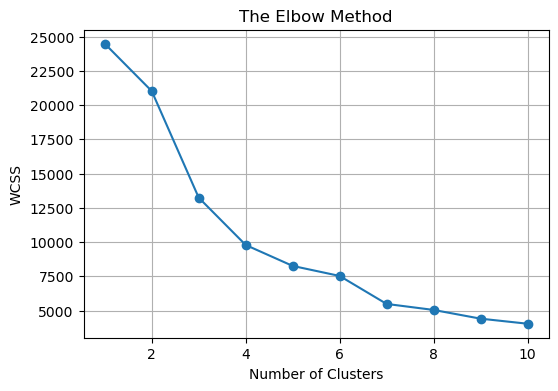

In [47]:
X = df.iloc[:, 1:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [49]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

sil_score = silhouette_score(X_scaled, df["cluster"])
print(f"Silhouette Score: {sil_score:.3f}")

cluster_centers = kmeans.cluster_centers_
cluster_scores = []

for center in cluster_centers:
    score = center[0]*2 + center[2]*3 - center[1]*1.5 - center[4]*4 + center[6]*0.5
    cluster_scores.append(score)

min_score = min(cluster_scores)
max_score = max(cluster_scores)
score_map = {
    i: int(1000 * (s - min_score) / (max_score - min_score)) for i, s in enumerate(cluster_scores)
}

df["credit_score"] = df["cluster"].map(score_map)
df[["wallet", "credit_score", "cluster"]].head()

Silhouette Score: 0.615


wallet  credit_score  cluster
0  0x00000000001accfa9cef68cf5371a23025b6d4b6             0        0
1  0x000000000051d07a4fb3bd10121a343d85818da6             0        0
2  0x000000000096026fb41fc39f9875d164bd82e2dc             0        0
3  0x0000000000e189dd664b9ab08a33c4839953852c            38        4
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee           264        2

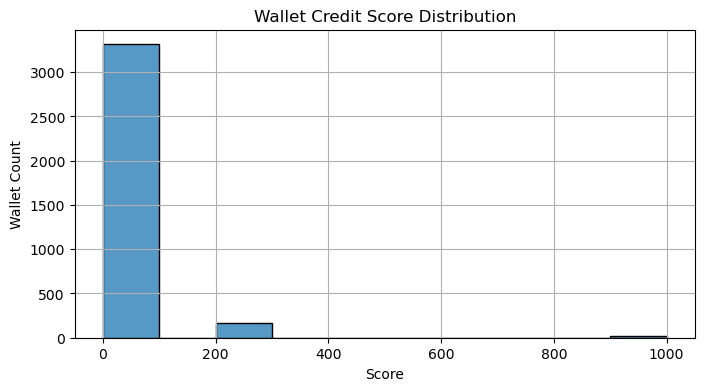

In [51]:
plt.figure(figsize=(8,4))
sns.histplot(df["credit_score"], bins=10, kde=False)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.show()


In [53]:
df[["wallet", "credit_score", "cluster"]].to_csv("wallet_scores.csv", index=False)
print(" Saved to wallet_scores.csv")


 Saved to wallet_scores.csv


In [55]:
pd.read_csv("wallet_scores.csv").head()

wallet  credit_score  cluster
0  0x00000000001accfa9cef68cf5371a23025b6d4b6             0        0
1  0x000000000051d07a4fb3bd10121a343d85818da6             0        0
2  0x000000000096026fb41fc39f9875d164bd82e2dc             0        0
3  0x0000000000e189dd664b9ab08a33c4839953852c            38        4
4  0x0000000002032370b971dabd36d72f3e5a7bf1ee           264        2